In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import mlflow

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set graphs style
sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
plt.style.use('seaborn-v0_8')
%matplotlib inline

For this particular model, we initally have to carry ut some feature engineering, construct a categorical variable

In [3]:
# Load the data

path = '../data/raw/Timeseries_11.573_-72.814_E5_3kWp_crystSi_16_v45deg_2005_2023.csv'

# Lines to ignore
n = 10
m = 13

# Read the file
with open(path, 'r') as file:
    lines = file.readlines()

# Remove first nth and last mth lines
csvLines = lines[n:-m]

# Join the lines and load the to pandas
csvData = StringIO("".join(csvLines))
rawData = pd.read_csv(csvData)

rawData

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,20050101:0030,0.00,0.00,0.00,0.00,0.00,25.87,3.86,0.0
1,20050101:0130,0.00,0.00,0.00,0.00,0.00,25.28,3.72,0.0
2,20050101:0230,0.00,0.00,0.00,0.00,0.00,24.88,3.72,0.0
3,20050101:0330,0.00,0.00,0.00,0.00,0.00,24.56,3.66,0.0
4,20050101:0430,0.00,0.00,0.00,0.00,0.00,24.45,3.45,0.0
...,...,...,...,...,...,...,...,...,...
166531,20231231:1930,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0
166532,20231231:2030,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0
166533,20231231:2130,1303.80,351.40,84.11,4.42,14.16,29.41,5.66,0.0
166534,20231231:2230,86.74,0.00,42.63,1.47,0.91,28.66,5.45,0.0


In [4]:
# Correct the time column

# Convert to datetime
rawData['time'] = pd.to_datetime(rawData['time'], format='%Y%m%d:%H%M')
rawData

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,2005-01-01 00:30:00,0.00,0.00,0.00,0.00,0.00,25.87,3.86,0.0
1,2005-01-01 01:30:00,0.00,0.00,0.00,0.00,0.00,25.28,3.72,0.0
2,2005-01-01 02:30:00,0.00,0.00,0.00,0.00,0.00,24.88,3.72,0.0
3,2005-01-01 03:30:00,0.00,0.00,0.00,0.00,0.00,24.56,3.66,0.0
4,2005-01-01 04:30:00,0.00,0.00,0.00,0.00,0.00,24.45,3.45,0.0
...,...,...,...,...,...,...,...,...,...
166531,2023-12-31 19:30:00,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0
166532,2023-12-31 20:30:00,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0
166533,2023-12-31 21:30:00,1303.80,351.40,84.11,4.42,14.16,29.41,5.66,0.0
166534,2023-12-31 22:30:00,86.74,0.00,42.63,1.47,0.91,28.66,5.45,0.0


In [5]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166536 entries, 0 to 166535
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    166536 non-null  datetime64[ns]
 1   P       166536 non-null  float64       
 2   Gb(i)   166536 non-null  float64       
 3   Gd(i)   166536 non-null  float64       
 4   Gr(i)   166536 non-null  float64       
 5   H_sun   166536 non-null  float64       
 6   T2m     166536 non-null  float64       
 7   WS10m   166536 non-null  float64       
 8   Int     166536 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 11.4 MB


In [6]:
data = rawData.copy()

In [7]:
# Separate time information

data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.weekday
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [8]:
data

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int,hour,day_of_week,month,year,is_weekend
0,2005-01-01 00:30:00,0.00,0.00,0.00,0.00,0.00,25.87,3.86,0.0,0,5,1,2005,1
1,2005-01-01 01:30:00,0.00,0.00,0.00,0.00,0.00,25.28,3.72,0.0,1,5,1,2005,1
2,2005-01-01 02:30:00,0.00,0.00,0.00,0.00,0.00,24.88,3.72,0.0,2,5,1,2005,1
3,2005-01-01 03:30:00,0.00,0.00,0.00,0.00,0.00,24.56,3.66,0.0,3,5,1,2005,1
4,2005-01-01 04:30:00,0.00,0.00,0.00,0.00,0.00,24.45,3.45,0.0,4,5,1,2005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166531,2023-12-31 19:30:00,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0,19,6,12,2023,1
166532,2023-12-31 20:30:00,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0,20,6,12,2023,1
166533,2023-12-31 21:30:00,1303.80,351.40,84.11,4.42,14.16,29.41,5.66,0.0,21,6,12,2023,1
166534,2023-12-31 22:30:00,86.74,0.00,42.63,1.47,0.91,28.66,5.45,0.0,22,6,12,2023,1


In [9]:
# Get seasons

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
data['season'] = data['month'].apply(get_season)
data

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int,hour,day_of_week,month,year,is_weekend,season
0,2005-01-01 00:30:00,0.00,0.00,0.00,0.00,0.00,25.87,3.86,0.0,0,5,1,2005,1,Winter
1,2005-01-01 01:30:00,0.00,0.00,0.00,0.00,0.00,25.28,3.72,0.0,1,5,1,2005,1,Winter
2,2005-01-01 02:30:00,0.00,0.00,0.00,0.00,0.00,24.88,3.72,0.0,2,5,1,2005,1,Winter
3,2005-01-01 03:30:00,0.00,0.00,0.00,0.00,0.00,24.56,3.66,0.0,3,5,1,2005,1,Winter
4,2005-01-01 04:30:00,0.00,0.00,0.00,0.00,0.00,24.45,3.45,0.0,4,5,1,2005,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166531,2023-12-31 19:30:00,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0,19,6,12,2023,1,Winter
166532,2023-12-31 20:30:00,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0,20,6,12,2023,1,Winter
166533,2023-12-31 21:30:00,1303.80,351.40,84.11,4.42,14.16,29.41,5.66,0.0,21,6,12,2023,1,Winter
166534,2023-12-31 22:30:00,86.74,0.00,42.63,1.47,0.91,28.66,5.45,0.0,22,6,12,2023,1,Winter


Now, we must handle the categorical variables

In [10]:
data = pd.get_dummies(data, columns=['season'], drop_first=True)
data


,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int,hour,day_of_week,month,year,is_weekend,season_Spring,season_Summer,season_Winter
0,2005-01-01 00:30:00,0.00,0.00,0.00,0.00,0.00,25.87,3.86,0.0,0,5,1,2005,1,False,False,True
1,2005-01-01 01:30:00,0.00,0.00,0.00,0.00,0.00,25.28,3.72,0.0,1,5,1,2005,1,False,False,True
2,2005-01-01 02:30:00,0.00,0.00,0.00,0.00,0.00,24.88,3.72,0.0,2,5,1,2005,1,False,False,True
3,2005-01-01 03:30:00,0.00,0.00,0.00,0.00,0.00,24.56,3.66,0.0,3,5,1,2005,1,False,False,True
4,2005-01-01 04:30:00,0.00,0.00,0.00,0.00,0.00,24.45,3.45,0.0,4,5,1,2005,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166531,2023-12-31 19:30:00,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0,19,6,12,2023,1,False,False,True
166532,2023-12-31 20:30:00,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0,20,6,12,2023,1,False,False,True
166533,2023-12-31 21:30:00,1303.80,351.40,84.11,4.42,14.16,29.41,5.66,0.0,21,6,12,2023,1,False,False,True
166534,2023-12-31 22:30:00,86.74,0.00,42.63,1.47,0.91,28.66,5.45,0.0,22,6,12,2023,1,False,False,True


Now we proceed to create the target column, for that we consider the Chebyshov inequiality, so the normal power production are around the mean
value of stochastic with a proximity of 1 standart deviation, e.g. 68% percent of the values are normal power production

In [11]:
mean = data['P'].mean()
std = data['P'].std()

def target(power):
    if power < (mean - mean/2):
        return 'Low'
    elif ( power > (mean + mean/2) ):
        return 'High'
    else:
        return 'Normal'
    
data['Target'] = data['P'].apply(target)

In [12]:
data[data['Target'] == 'High' ]

,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int,hour,day_of_week,month,year,is_weekend,season_Spring,season_Summer,season_Winter,Target
13,2005-01-01 13:30:00,1445.87,334.54,136.14,8.39,29.14,24.17,4.41,0.0,13,5,1,2005,1,False,False,True,High
14,2005-01-01 14:30:00,1912.95,452.55,175.37,13.24,40.51,25.22,4.48,0.0,14,5,1,2005,1,False,False,True,High
15,2005-01-01 15:30:00,2417.65,642.32,163.40,18.71,49.68,26.38,4.76,0.0,15,5,1,2005,1,False,False,True,High
16,2005-01-01 16:30:00,2535.57,684.45,164.56,21.14,54.89,27.38,5.17,0.0,16,5,1,2005,1,False,False,True,High
17,2005-01-01 17:30:00,1828.94,373.58,231.22,15.86,54.35,28.05,5.24,0.0,17,5,1,2005,1,False,False,True,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166529,2023-12-31 17:30:00,2334.45,621.12,175.18,19.78,54.23,30.70,4.34,0.0,17,6,12,2023,1,False,False,True,High
166530,2023-12-31 18:30:00,2166.59,530.34,204.77,17.11,48.13,30.66,4.62,0.0,18,6,12,2023,1,False,False,True,High
166531,2023-12-31 19:30:00,1912.60,473.70,171.50,13.06,38.45,30.61,4.62,0.0,19,6,12,2023,1,False,False,True,High
166532,2023-12-31 20:30:00,1564.37,388.15,134.76,8.55,26.82,30.14,5.31,0.0,20,6,12,2023,1,False,False,True,High


In [13]:
print(mean - mean/2)

429.9238189340443


Start experiments and runs

In [14]:
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

Tracking Server URI: 'file:///home/sebastian/Desktop/For_studyng/TalentoTech/FinalProject/Talento_tech_final/ModelGenerate/mlruns'


In [45]:
import os

In [57]:
def RandomForestClassifierRun(data:pd.DataFrame, nStimators:int,maxDepth:int,criterion:str ,testDataPercentage:float,randomState:int, run_name:str):
    
    X = data.drop(columns=['time','Target','P','Int'])
    y = data['Target']
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Separate train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=testDataPercentage,random_state=40) 
    
    # Create the model
    model = RandomForestClassifier(criterion=criterion,n_estimators=nStimators,max_depth=maxDepth)
    
    # Fit the model
    model.fit(X_train,y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    trainpred = model.predict(X_train)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, predictions)
    testReport = classification_report(y_test,predictions)
    trainReport = classification_report(y_train,trainpred)
    
    print('test Report \n',testReport)
    print('--------------------------------')
    print('train Report \n',trainReport)
    print('--------------------------------')
    print('Accuracy: ',accuracy )
    
    # Feature importance
    feature_importances = model.feature_importances_
    features = X.columns
    indices = np.argsort(feature_importances)
    
    
    # Plot results
    output_dir = './randomForestImages/'
    os.makedirs(output_dir, exist_ok=True)

    
    # Confusion matrix
    cm_test = confusion_matrix(y_test, predictions, labels=['Low', 'Normal', 'High'])
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Low', 'Normal', 'High'])
    disp_test.plot()
    plt.grid(False)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, 'confusionMatrix_' + run_name + '.png'))

    
    # Feature importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.barh(range(len(indices)), feature_importances[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.savefig(os.path.join(output_dir, 'featureImportance_' + run_name + '.png'))
    
    with mlflow.start_run(run_name= run_name): 
        
        mlflow.log_param('run name',run_name )
        
        mlflow.log_param('Test percentage', testDataPercentage)
        mlflow.log_param('n_stimators', nStimators)
        mlflow.log_param('max_depth', maxDepth ),
        mlflow.log_metric('accuracy', accuracy)
        
        mlflow.sklearn.log_model(model, artifact_path='model_rf')

In [58]:
# Set the experiment
experiment_name = "RandomForest_Classifier_Experiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/sebastian/Desktop/For_studyng/TalentoTech/FinalProject/Talento_tech_final/ModelGenerate/mlruns/301905116928481185', creation_time=1733239920864, experiment_id='301905116928481185', last_update_time=1733239920864, lifecycle_stage='active', name='RandomForest_Classifier_Experiment', tags={}>

test Report 
               precision    recall  f1-score   support

        High       0.99      1.00      1.00     11818
         Low       1.00      1.00      1.00     18006
      Normal       0.98      0.98      0.98      3484

    accuracy                           1.00     33308
   macro avg       0.99      0.99      0.99     33308
weighted avg       1.00      1.00      1.00     33308

--------------------------------
train Report 
               precision    recall  f1-score   support

        High       1.00      1.00      1.00     47983
         Low       1.00      1.00      1.00     71258
      Normal       0.99      0.99      0.99     13987

    accuracy                           1.00    133228
   macro avg       1.00      1.00      1.00    133228
weighted avg       1.00      1.00      1.00    133228

--------------------------------
Accuracy:  0.9951363035907289


2024/12/03 11:18:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


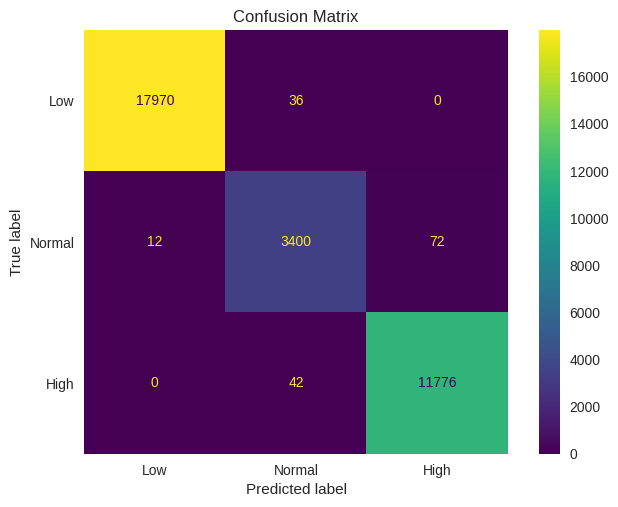

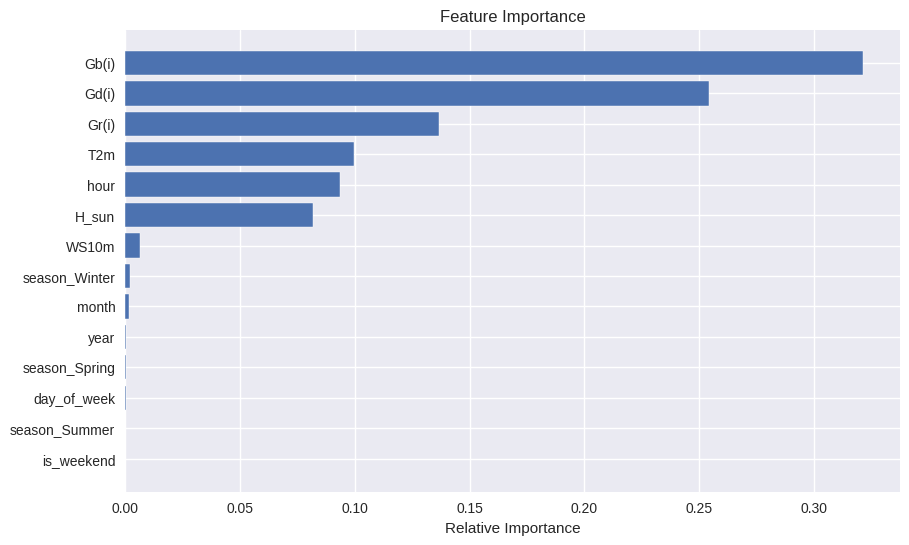

In [59]:
# Run experiments
RandomForestClassifierRun(data=data,nStimators=10,maxDepth=10,criterion='gini',testDataPercentage=0.2,randomState=42,run_name='run_1')

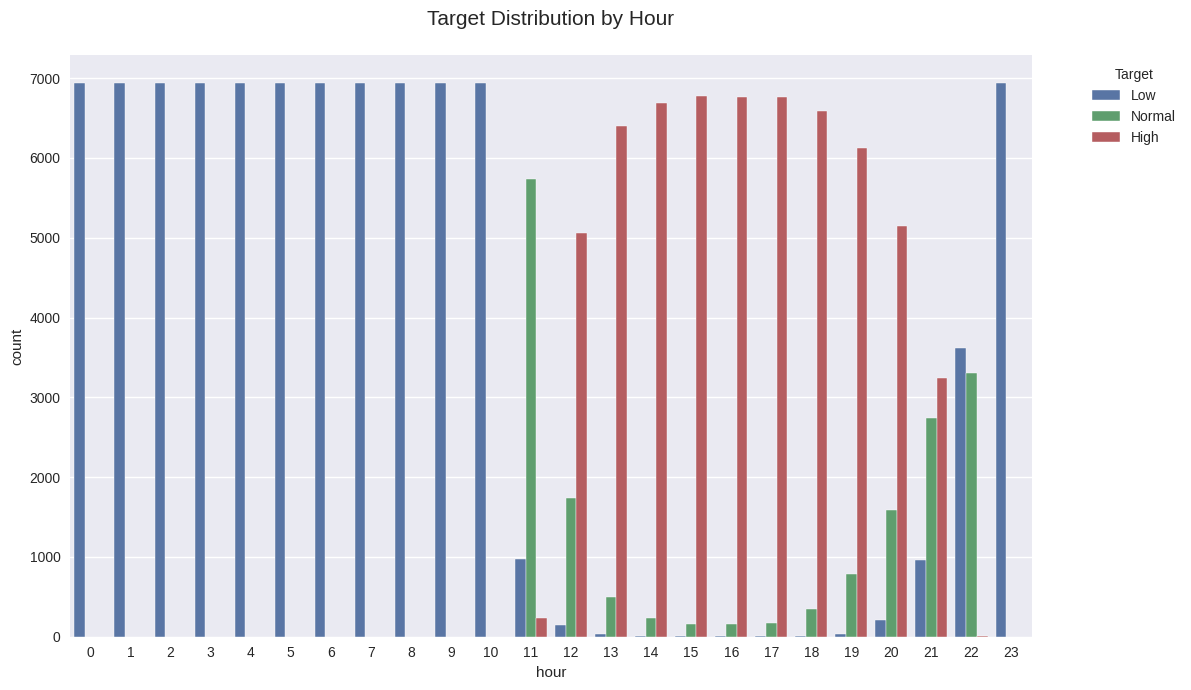

In [65]:

# Hourly distribution of classes
fig = plt.figure(figsize=(12,7))
sns.countplot(data=data, x='hour', hue='Target')
plt.title("Target Distribution by Hour\n", fontsize=15)

plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()  # Ajustar la figura para evitar recortes
plt.show()


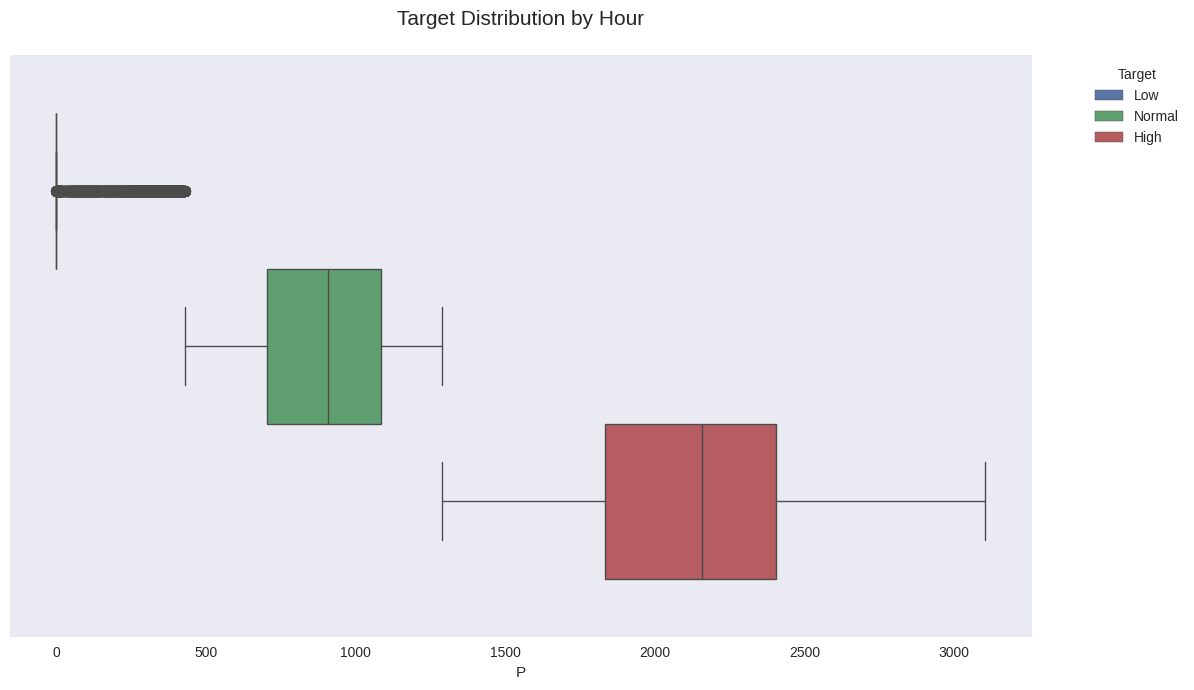

In [71]:
# Hourly distribution of classes
fig = plt.figure(figsize=(12,7))
sns.boxplot(data=data, x='P', hue='Target')
plt.title("Target Distribution by Hour\n", fontsize=15)

plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.grid(False)
plt.tight_layout()  # Ajustar la figura para evitar recortes
plt.show()
